In [24]:
import csv
import datetime
import pprint
pp = pprint.PrettyPrinter(indent=4)

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def load_telemetry(file):
    """
    Loads the Telemetry data file
    """
    long_lat_parser = lambda r: { 'longitude': float(r[2]), 'latitude': float(r[3]), 'altitude': float(r[4]) }
    local_parser = lambda r: { 'north': float(r[2]), 'east': float(r[3]), 'down': float(r[4]) }
    parser = {
        'STATE' : lambda r: {'armed': bool((r[2])), 'guided': bool((r[3]))},
        'GLOBAL_POSITION' : long_lat_parser,
        'GLOBAL_HOME' : long_lat_parser,
        'LOCAL_POSITION' : local_parser,
        'LOCAL_VELOCITY' : local_parser
    }
    messages = []
    with open(file) as dataFile:
        dataReader = csv.reader(dataFile)
        for row in dataReader:
            message = {}
            type = row[0][6:]
            message['type'] = type
            message['timestamp'] = datetime.datetime.fromtimestamp(float(row[1]))
            this_parser = parser[type]
            rest = {}
            if this_parser:
                rest = this_parser(row)
            else:
                rest['row'] = row
            messages.append({**message, **rest})

    return messages

def get_north_east_down(type, tl):
    """
    Returns `[north, east, down, timestamp]` telemetry for the `type` on the telemetry `tl`
    """
    north = []
    east = []
    down = []
    timestamp = []
    epoch = datetime.datetime.utcfromtimestamp(0)
    for t in tl:
        if t['type'] == type:
            north.append(t.get('north', 0))  # Use .get() to avoid KeyError
            east.append(t.get('east', 0))    # Default to 0 if key is missing
            down.append(t.get('down', 0))
            timestamp.append((t['timestamp'] - epoch).total_seconds())
    return [np.array(north), np.array(east), np.array(down), np.array(timestamp)]

def plot_3d_trajectory(east, north, down, title):
    """
    Plot the trajectory defined by `[x, y, z]`
    """
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    up = -down
    ax.plot(east, north, up)
    ax.plot(east, north, up, 'ro')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(title)
    plt.show()

def plot_xy_trajectory(east, north, down, timestamp, title):
    """
    Plot the `[x, y]` trajectory and altitude
    """

    fig, axes = plt.subplots(1, 2, figsize=[20,10])
    axP = axes[0]
    axP.plot(east, north,linewidth=5)
    axP.plot(east, north, 'ro')
    axP.set_xlabel('X [m]',fontsize=20)
    axP.set_ylabel('Y [m]',fontsize=20)
    axP.tick_params(axis='x', labelsize=20)
    axP.tick_params(axis='y', labelsize=20)
    axP.grid()
    axP.set_title('Ground Trajectory',fontsize=20)

    axH = axes[1]
    up = -down
    axH.plot(timestamp, up,linewidth=5)
    axH.plot(timestamp, up, 'ro')
    axH.set_xlabel('Time [s]',fontsize=20)
    axH.set_ylabel('Altitude [m]',fontsize=20)
    axH.tick_params(axis='x', labelsize=20)
    axH.tick_params(axis='y', labelsize=20)
    axH.grid()
    axH.set_title('Altitude',fontsize=20)

    plt.suptitle(title, fontsize=24)

def plot_velocity(east, north, down, timestamp, title):
    """
    Plot velocity on the 3D axis, excluding points where time or velocity is zero.
    """
    fig, axes = plt.subplots(1, 3, figsize=[20, 10])
    values = [east, north, -down]
    sub_titles = ['X Velocity', 'Y Velocity', 'Z Velocity']

    for ax, value, sub_title in zip(axes, values, sub_titles):
        # Filter out points where time or velocity is zero
        non_zero_indices = np.where((timestamp != 0) & (value != 0))
        filtered_time = timestamp[non_zero_indices]
        filtered_value = value[non_zero_indices]

        ax.plot(filtered_time, filtered_value, linewidth=5)
        ax.plot(filtered_time, filtered_value, 'ro')
        ax.set_xlabel('Time [s]', fontsize=20)
        ax.set_ylabel('Velocity [m/s]', fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid()
        ax.set_title(sub_title, fontsize=20)

    plt.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()



def plot_local_position_and_velocity(file, title):
    """
    Plot local position and velocity for the telemetry file `file`
    """
    tl = load_telemetry(file)
    local_north, local_east, local_down, local_timestamp = get_north_east_down('LOCAL_POSITION', tl)
    v_local_north, v_local_east, v_local_down, v_timestamp = get_north_east_down('LOCAL_VELOCITY', tl)
    plot_3d_trajectory(local_east, local_north, local_down, title + ' -> Trajectory')
    plot_xy_trajectory(local_east, local_north, local_down, local_timestamp, title + ' -> Trajectory')
    plot_velocity(v_local_east, v_local_north, v_local_down, v_timestamp, title + ' -> Velocity')



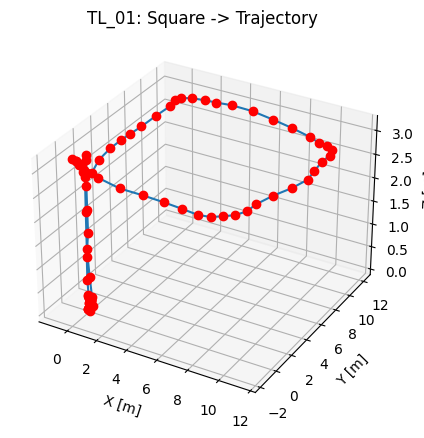

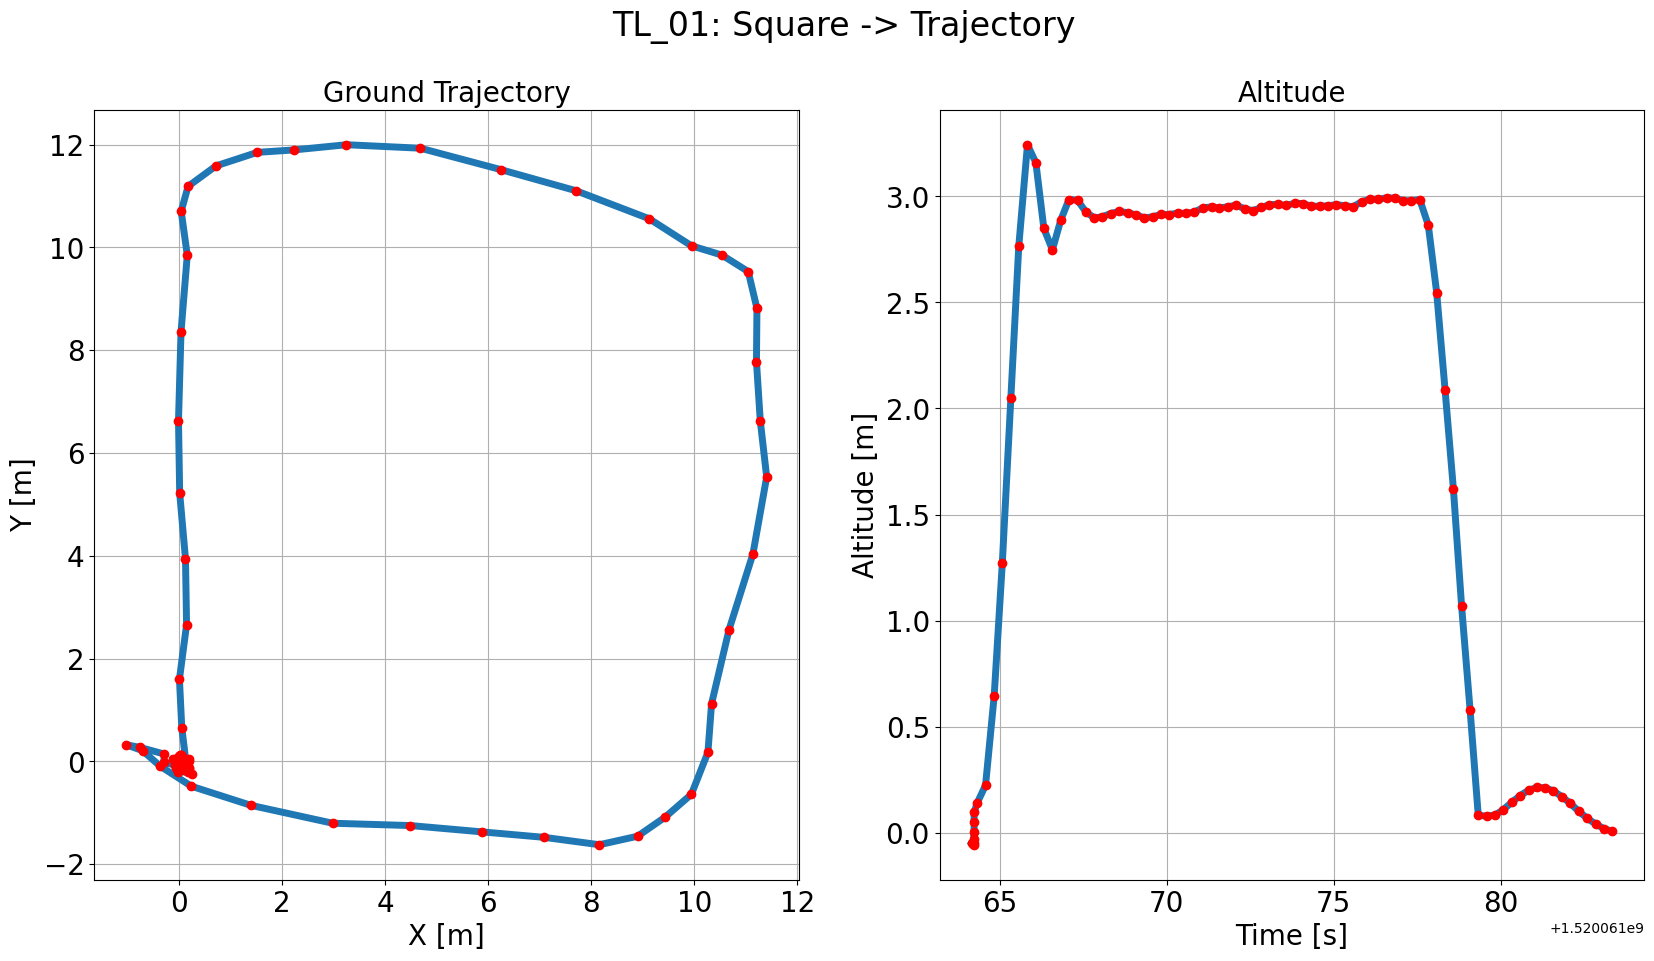

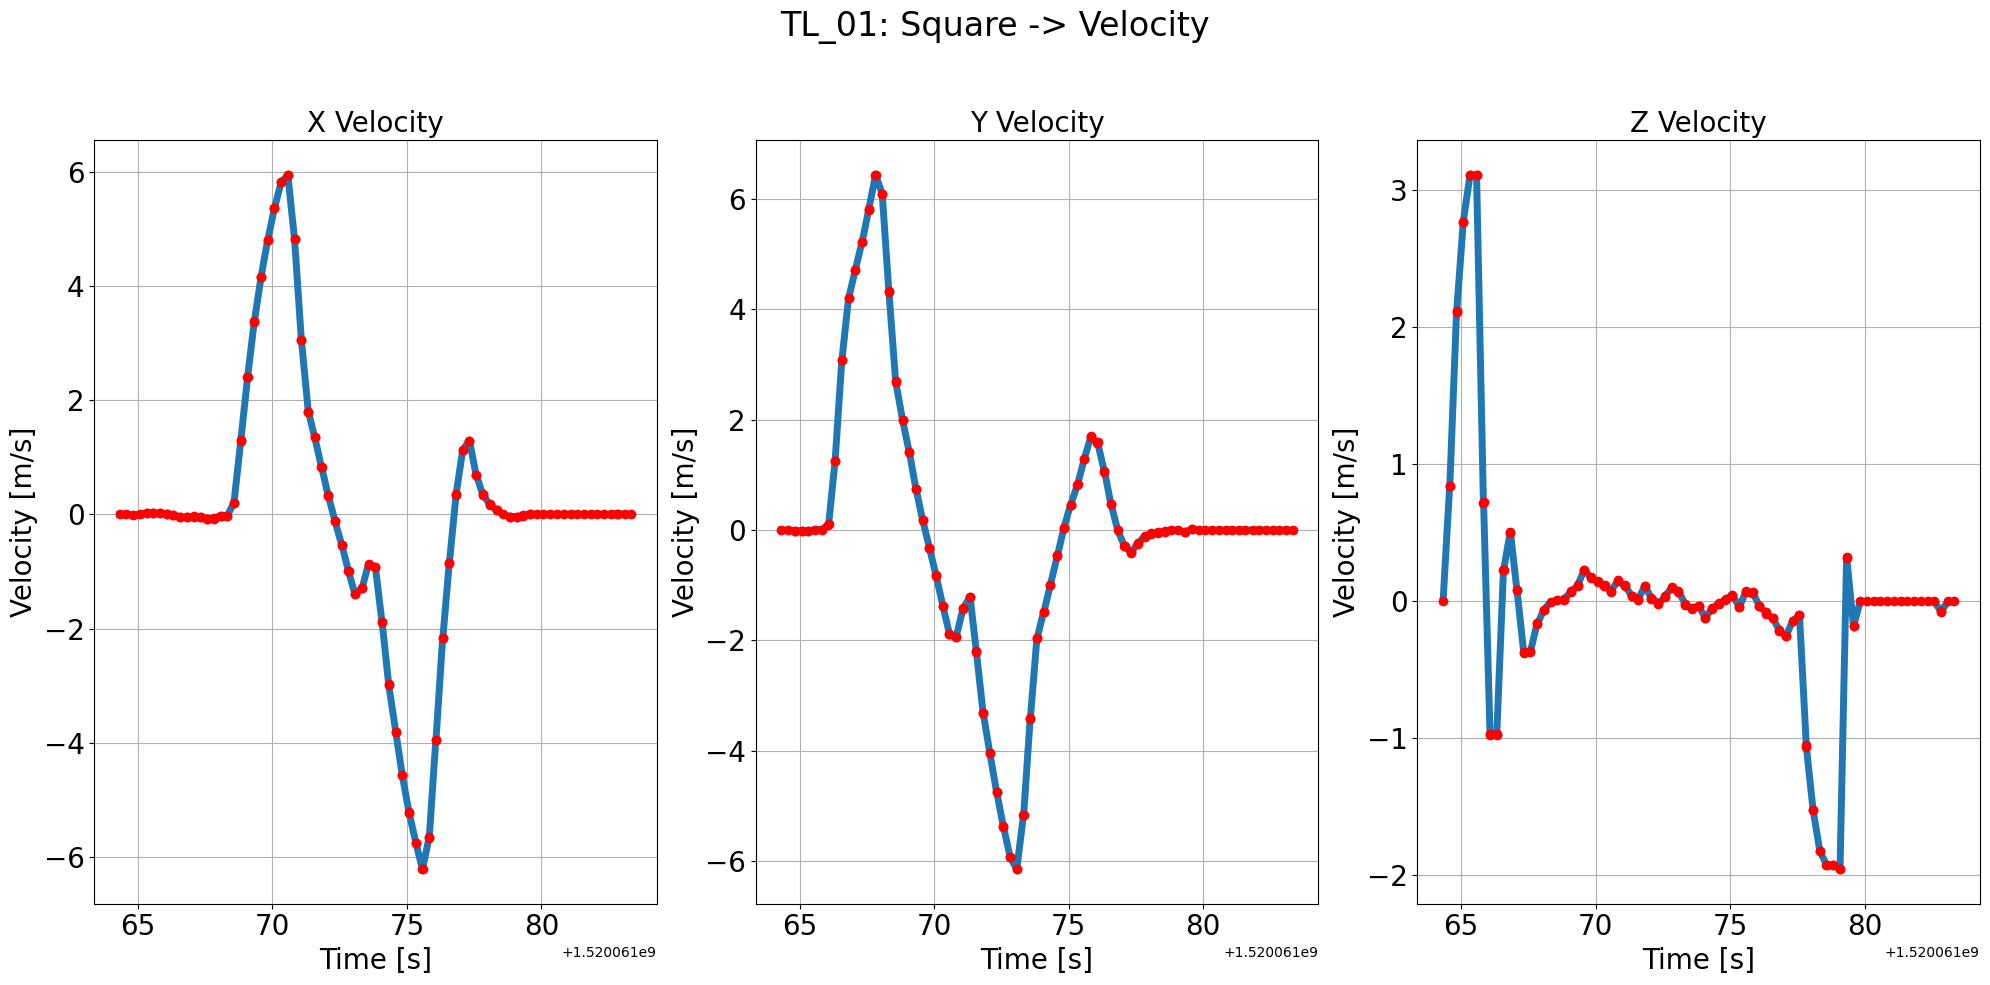

In [35]:
plot_local_position_and_velocity('/content/TLog_01.txt', 'TL_01: Square')